In [26]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint

## Config

In [27]:
PROJECT_ROOT = os.path.abspath("..")

DATA_DIR = os.path.join(PROJECT_ROOT, "data/Rice_Leaf_AUG")
BASELINE_DIR = os.path.join(PROJECT_ROOT, "models/baseline/mobilenetv2_rice")
INFERENCE_DIR = os.path.join(PROJECT_ROOT, "models/baseline/mobilenetv2_rice_infer/baseline_best.keras")

os.makedirs(BASELINE_DIR, exist_ok=True)

In [28]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS_BASELINE = 20
EPOCHS_FINETUNE = 10

NUM_CLASSES = 6
LR_BASELINE = 1e-3
LR_FINETUNE = 1e-4
SEED = 42


## Data Splitting

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(class_names)


Found 3829 files belonging to 6 classes.
Using 3064 files for training.
Found 3829 files belonging to 6 classes.
Using 765 files for validation.
['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']


## Data augmentation (for training only)

In [30]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x, training=True), y

train_ds_aug = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Training (base model)

In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=INFERENCE_DIR,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]


history_baseline = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_BASELINE,
    callbacks=callbacks
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4133 - loss: 1.5144
Epoch 1: val_accuracy improved from -inf to 0.64967, saving model to /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice_infer/baseline_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.4144 - loss: 1.5117 - val_accuracy: 0.6497 - val_loss: 0.9109
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6659 - loss: 0.8936
Epoch 2: val_accuracy improved from 0.64967 to 0.71895, saving model to /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice_infer/baseline_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.6659 - loss: 0.8934 - val_accuracy: 0.7190 - val_loss: 0.7745
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7119 - loss: 0.7712
Epoch 3: val_accuracy improved from 0.71895 to 0.74510, saving model to /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice_infer/base

## Evaluate (base model)

2026-01-03 14:54:05.192831: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.74      0.79      0.76       109
           Brown Spot       0.86      0.83      0.85       139
    Healthy Rice Leaf       0.98      0.98      0.98       133
           Leaf Blast       0.68      0.70      0.69       111
           Leaf scald       0.80      0.79      0.79       137
        Sheath Blight       0.88      0.85      0.87       136

             accuracy                           0.83       765
            macro avg       0.82      0.82      0.82       765
         weighted avg       0.83      0.83      0.83       765



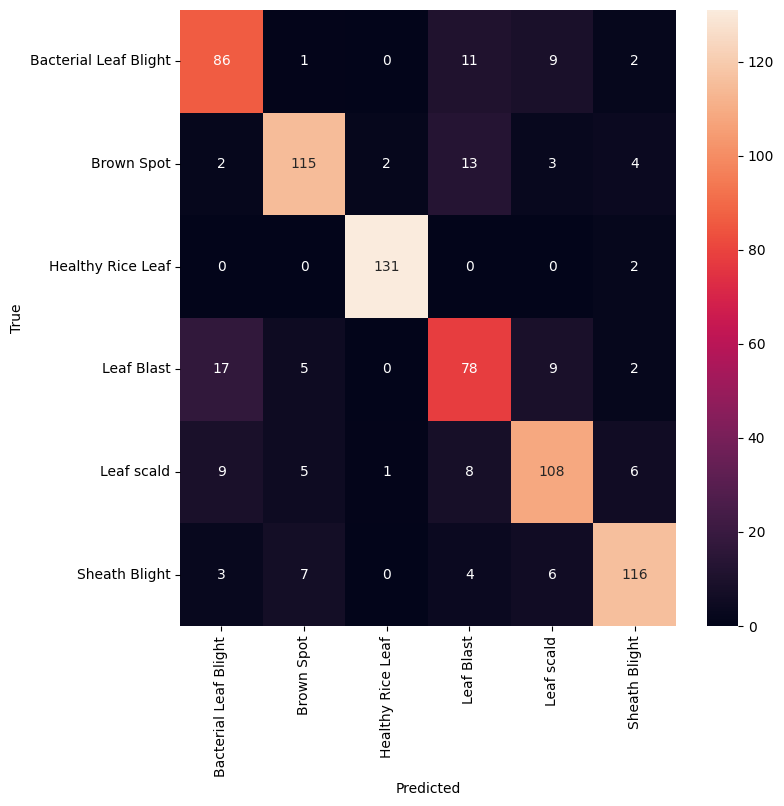

In [18]:
val_images = []
val_labels = []

for x, y in val_ds:
    val_images.append(x)
    val_labels.append(y)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Finetuning

In [19]:
base_model.trainable = True

for layer in base_model.layers[:-80]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_finetune = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6076 - loss: 1.3338
Epoch 1: val_accuracy did not improve from 0.82876
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 268ms/step - accuracy: 0.6085 - loss: 1.3298 - val_accuracy: 0.6052 - val_loss: 1.8479
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8219 - loss: 0.4963
Epoch 2: val_accuracy did not improve from 0.82876
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.8221 - loss: 0.4959 - val_accuracy: 0.5778 - val_loss: 2.0485
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8920 - loss: 0.2975
Epoch 3: val_accuracy did not improve from 0.82876
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.8920 - loss: 0.2975 - val_accuracy: 0.5373 - val_loss: 2.4640
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9134 - loss: 0.2459
Epoch 4: val_accuracy did not improve from 0.82876
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.9134 - loss: 0.2458 - val_accuracy: 0.6092

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.47      0.90      0.62       109
           Brown Spot       0.76      0.83      0.79       139
    Healthy Rice Leaf       0.58      1.00      0.73       133
           Leaf Blast       0.51      0.40      0.45       111
           Leaf scald       0.75      0.42      0.54       137
        Sheath Blight       1.00      0.11      0.20       136

             accuracy                           0.61       765
            macro avg       0.68      0.61      0.56       765
         weighted avg       0.69      0.61      0.56       765



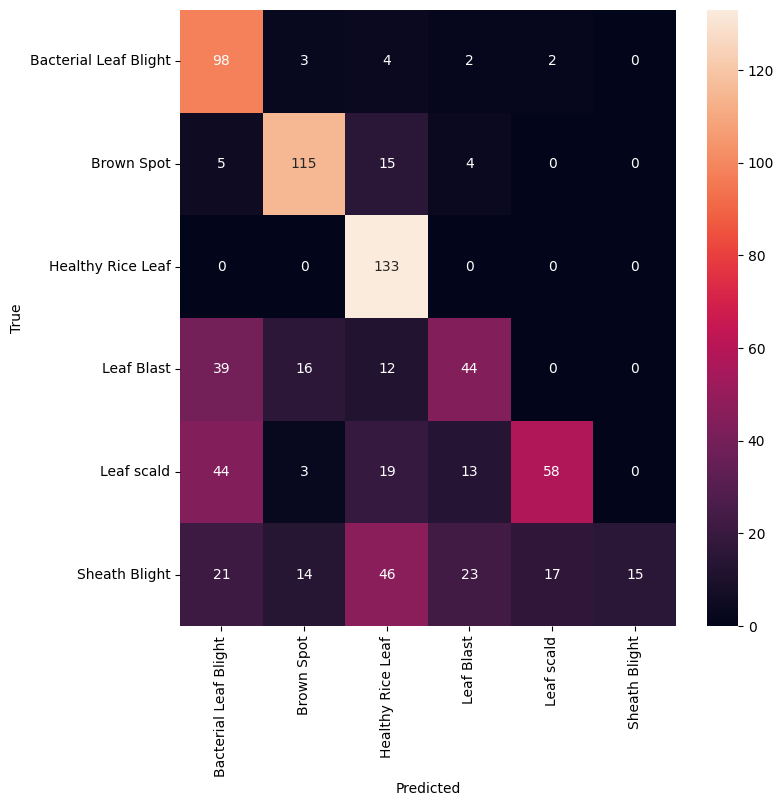

In [20]:
preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Load Best Model

In [23]:
best_model = tf.keras.models.load_model(INFERENCE_DIR)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.74      0.79      0.76       109
           Brown Spot       0.86      0.83      0.85       139
    Healthy Rice Leaf       0.98      0.98      0.98       133
           Leaf Blast       0.68      0.70      0.69       111
           Leaf scald       0.80      0.79      0.79       137
        Sheath Blight       0.88      0.85      0.87       136

             accuracy                           0.83       765
            macro avg       0.82      0.82      0.82       765
         weighted avg       0.83      0.83      0.83       765



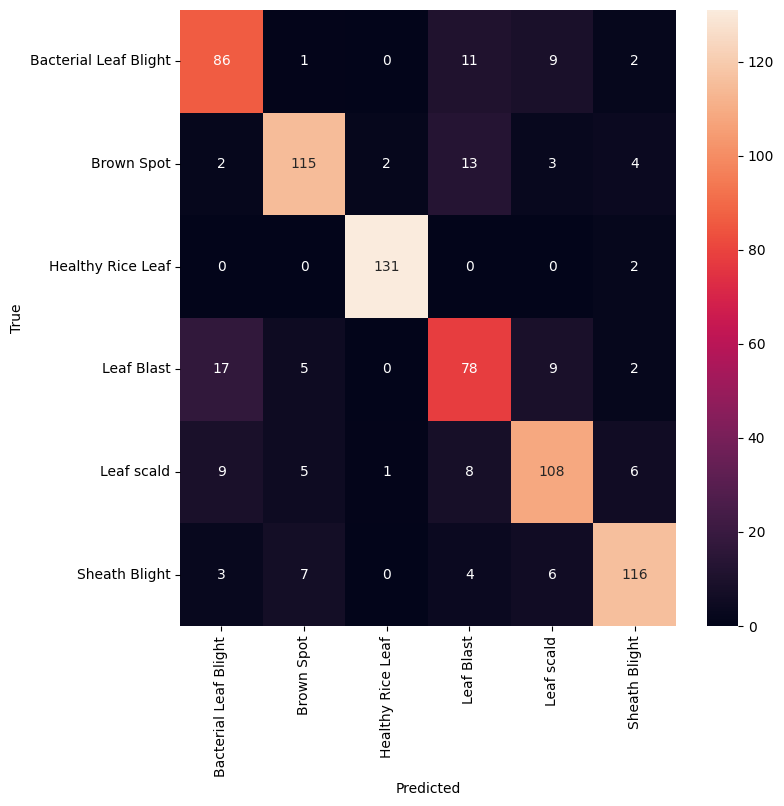

In [24]:
preds = best_model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Model Export


In [25]:
model.export(BASELINE_DIR)
print("Saved baseline model to:", BASELINE_DIR)

INFO:tensorflow:Assets written to: /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice/assets


INFO:tensorflow:Assets written to: /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice/assets


Saved artifact at '/Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_632')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  10945569712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10963245008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11062050128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6433910848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  10963360048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11018672256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11061993888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11061997408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11061994944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11061995296: TensorSpec(shape=(), dtype=tf.resource, name